# Color

In [1]:
import matplotlib.pyplot as plt
import skimage

## Examples using `skimage.color.gray2rgb`

### Tinting gray-scale images
[link to example](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_tinting_grayscale_images.html#sphx-glr-auto-examples-color-exposure-plot-tinting-grayscale-images-py)

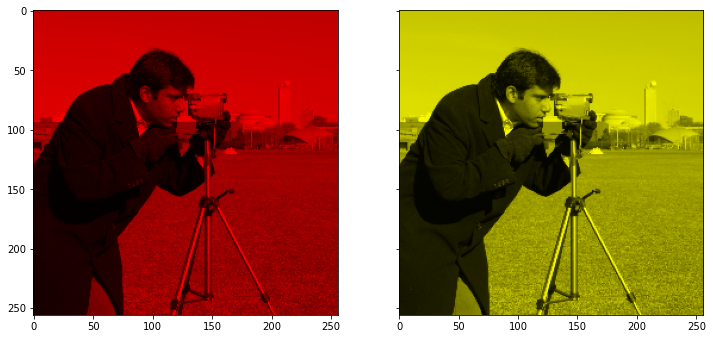

In [2]:
grayscale_image = skimage.img_as_float(skimage.data.camera()[::2, ::2])
image = skimage.color.gray2rgb(grayscale_image)

red_multiplier = [1, 0, 0]
yellow_multiplier = [1, 1, 0]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6), sharex=True, sharey=True)

ax1.imshow(red_multiplier * image)
ax2.imshow(yellow_multiplier * image)

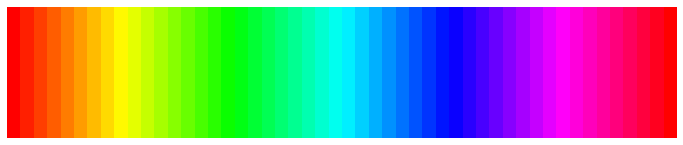

In [3]:
import numpy as np

hue_gradient = np.linspace(0,1)
hsv = np.ones(shape=(1, len(hue_gradient), 3), dtype=float)
hsv[:, :, 0] = hue_gradient

all_hues = skimage.color.hsv2rgb(hsv)

fig, ax = plt.subplots(figsize=(12, 6))
# Set image extent so hues go from 0 to 1 and the image is a nice aspect ratio
ax.imshow(all_hues, extent=(
    0 - 0.5 / len(hue_gradient),
    1 + 0.5 / len(hue_gradient), 0, 0.2
))
ax.set_axis_off()

Let's create a litte utility function to take an RGB image and:
1. Transform the RGB image to HSV
2. Set the hue and saturation
3. Transform the HSV image back to RGB

In [4]:
def colorize(image, hue, saturation=1):
    """Add color of the given hue to an RGB image.
    By default, set the saturation to 1 so that the colors pop!
    """

    hsv = skimage.color.rgb2hsv(image)
    hsv[:, :, 1] = saturation
    hsv[:, :, 0] = hue
    return skimage.color.hsv2rgb(hsv)

Using the function above, we plot six images with a linear gradient in the hue and a non-zero saturation:

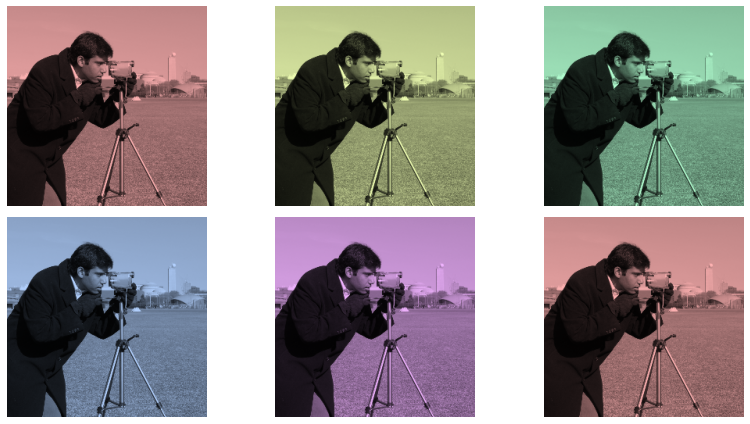

In [5]:
hue_rotations = np.linspace(0, 1, 6)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6), sharex=True, sharey=True)

for ax, hue in zip(axes.flat, hue_rotations):
    # Turn down the saturation to give it that vintage look.
    tinted_image = colorize(image, hue, saturation=0.3)
    ax.imshow(tinted_image, vmin=0, vmax=1)
    ax.set_axis_off()
fig.tight_layout()

You can combine this tinting effect with numpy slicing and fancy-indexing to selectively tint your images.

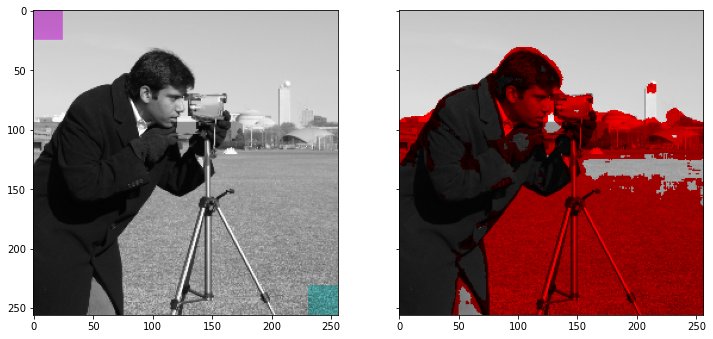

In [6]:
# Square regions defined as slices over the first two dimensions
top_left = (slice(25), ) * 2
bottom_right = (slice(-25, None), ) * 2

sliced_image = image.copy()
sliced_image[top_left] = colorize(image[top_left], 0.82, saturation=0.5)
sliced_image[bottom_right] = colorize(image[bottom_right], 0.5, saturation=0.5)

# Create a mask selecting regions with interesting texture.
noisy = skimage.filters.rank.entropy(skimage.util.img_as_ubyte(grayscale_image), np.ones((9,9)))
textured_regions = noisy > 4.25

# Note that using `colorize` here is a bit more difficult, since `rgb2hsv`
# expects an RGB image (height x width x channel), but fancy-indexing returns
# a set of RGB images (# pixels x channel).
masked_image = image.copy()
masked_image[textured_regions, :] *= red_multiplier

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), sharex=True, sharey=True)
ax1.imshow(sliced_image)
ax2.imshow(masked_image)

plt.show()

Let's go back and see how `noisy` and `textured_regions` actually look like:

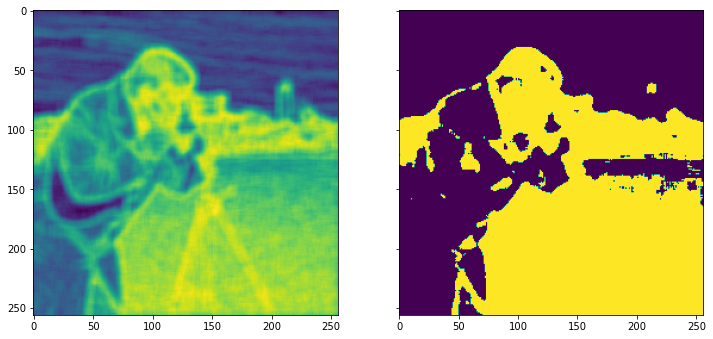

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,6), sharex=True, sharey=True)
ax1.imshow(noisy)
ax2.imshow(textured_regions)

### Circular and Elyptical Hough Transforms
[link to example](https://scikit-image.org/docs/stable/auto_examples/edges/plot_circular_elliptical_hough_transform.html#sphx-glr-auto-examples-edges-plot-circular-elliptical-hough-transform-py)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

#### Circle Detection

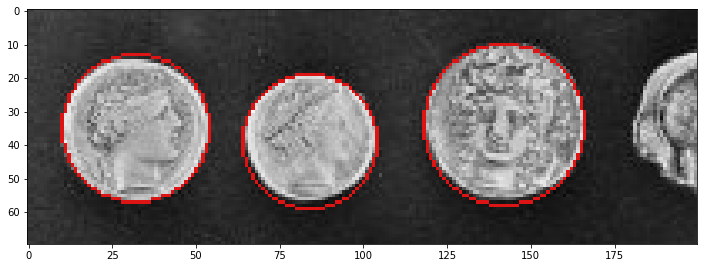

In [9]:
# Load picture and detect edges
image = skimage.util.img_as_ubyte(skimage.data.coins()[160:230, 70:270])
edges = skimage.feature.canny(image, sigma=3, low_threshold=10, high_threshold=50)

# Detect two radii
hough_radii = np.arange(20, 35, 2)
hough_res = skimage.transform.hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = skimage.transform.hough_circle_peaks(hough_res, hough_radii, total_num_peaks=3)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 6))
image = skimage.color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = skimage.draw.circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

#### Ellipse Detection

result: 7


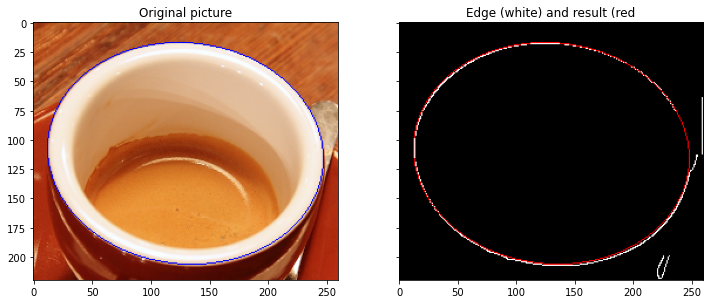

In [10]:
# Load picture, convert to grayscale and detect edges
image_rgb = skimage.data.coffee()[0:220, 160:420]
image_gray = skimage.color.rgb2gray(image_rgb)
edges = skimage.feature.canny(image_gray, sigma=2.0, low_threshold=0.55, high_threshold=0.8)

# Perform a Hough Transform
# The accuracy corresponds to the bin size of a major axis
# The value is chosen in order to get a single high accumulator.
# The threshold eliminates low accumulators
result = skimage.transform.hough_ellipse(edges, accuracy=20, threshold=250, min_size=100, max_size=120)
result.sort(order='accumulator')

print(f"result: {len(result)}")
# Estimated parameters for the ellipse
best = list(result[-1])
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

# Draw the ellipse on the original image
cy, cx = skimage.draw.ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0, 0, 255)
# Draw the edge (white) and the resulting ellipse (red)
edges = skimage.color.gray2rgb(skimage.util.img_as_ubyte(edges))
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,6), sharex=True, sharey=True)

ax1.set_title("Original picture")
ax1.imshow(image_rgb)

ax2.set_title("Edge (white) and result (red")
ax2.imshow(edges)

plt.show()

#### Region Boundary based RAGs
[link to example](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rag_boundary.html#sphx-glr-auto-examples-segmentation-plot-rag-boundary-py)

In [11]:
import skimage
from matplotlib import pyplot as plt

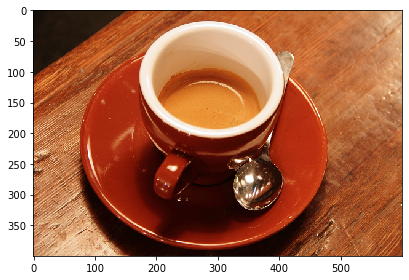

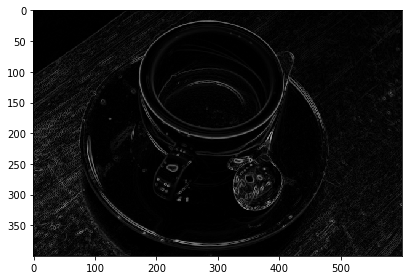

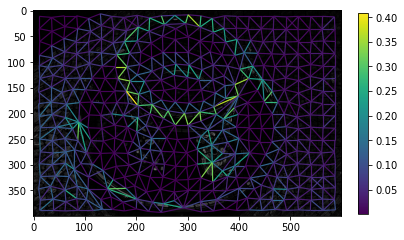

In [12]:
img = skimage.data.coffee()
gray_img = skimage.color.rgb2gray(img)

labels = skimage.segmentation.slic(img, compactness=30, n_segments=400, start_label=1)
edges = skimage.filters.sobel(gray_img)
edges_rgb = skimage.color.gray2rgb(edges)

g = skimage.future.graph.rag_boundary(labels, edges)

# Show image and edges beforehand
skimage.io.imshow(img)
skimage.io.show()
skimage.io.imshow(edges)
skimage.io.show()

# Show actual RAG
lc = skimage.future.graph.show_rag(
    labels, g, edges_rgb, img_cmap=None, edge_cmap='viridis', edge_width=1.2
)
plt.colorbar(lc, fraction=0.03)
skimage.io.show()

## Examples using `skimage.color.hed2rgb`
Heaematoxylin-Eosin-DAB (HED) to RGB color space conversion.

### Separate colors in immunohistochemical staining
[link to example](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_ihc_color_separation.html#sphx-glr-auto-examples-color-exposure-plot-ihc-color-separation-py)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

In this example we separate the immunohistochemical (IHC) staining from the hematoxylin counterstaining. The separation is achieved with the method known as "color deconvolution".

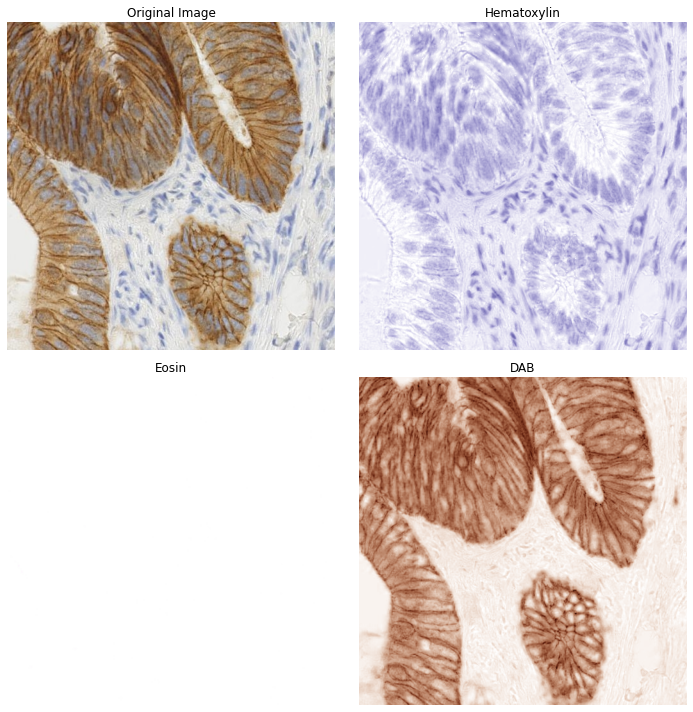

In [14]:
# Example IHC image
ihc_rgb = skimage.data.immunohistochemistry()

# Separate the stains from the IHC image
ihc_hed = skimage.color.rgb2hed(ihc_rgb)

# Create an RGB image for each of the stains
null = np.zeros_like(ihc_hed[:, :, 0])
ihc_h = skimage.color.hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
ihc_e = skimage.color.hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
ihc_d = skimage.color.hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

# Display
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(ihc_rgb)
ax[0].set_title("Original Image")

ax[1].imshow(ihc_h)
ax[1].set_title("Hematoxylin")

ax[2].imshow(ihc_e)
ax[2].set_title("Eosin") # Note that there is no Eosin in this image

ax[3].imshow(ihc_d)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

Now we can easily maipulate the hematoxylin and DAB channels:

(512, 512) (512, 512) (512, 512)


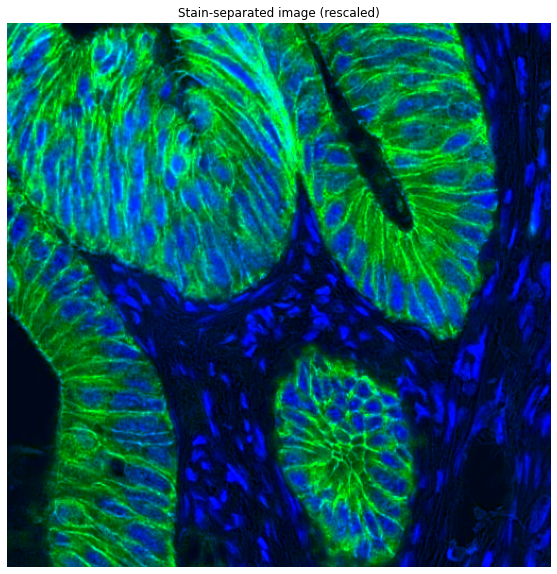

In [15]:
# Rescale hematoxylin and DAB channels and give them fluorescent look
h = skimage.exposure.rescale_intensity(
    ihc_hed[:, :, 0], out_range=(0,1),
    in_range=(0, np.percentile(ihc_hed[:, :, 0], 99)) 
)
d = skimage.exposure.rescale_intensity(
    ihc_hed[:, :, 2], out_range=(0,1),
    in_range=(0, np.percentile(ihc_hed[:, :, 2], 99))
)
# Cast the two channels into an RGB image, as the blue and green channels respectively
print(null.shape, d.shape, h.shape)
zdh = np.dstack((null, d, h))

fig = plt.figure(figsize=(10,10))
axs = plt.subplot(1, 1, 1, sharex=ax[0], sharey=ax[0])
axs.imshow(zdh)
axs.set_title('Stain-separated image (rescaled)')
axs.axis('off')
plt.show()

## Examples using `skimage.color.hsv2rgb`
HSV to RGB color space conversion.

### Tinting gray-scale 
[link to example](https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_tinting_grayscale_images.html#sphx-glr-auto-examples-color-exposure-plot-tinting-grayscale-images-py)

Already done

### Flood Fill
[link to example](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_floodfill.html#sphx-glr-auto-examples-segmentation-plot-floodfill-py)

Flood fill is an algorithm to indentify and/or change adjacent values in an image based on their similarity to an initial seed point. The conceptual analogy is the 'paint bucket' tool in many graphic editors.

#### Basic Example

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

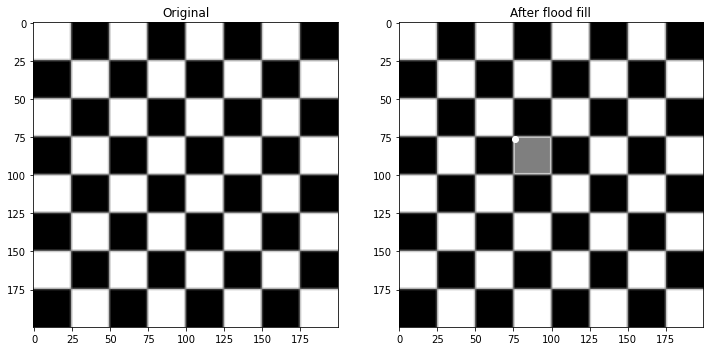

In [21]:
checkers = skimage.data.checkerboard()

# fill a square near the middle with value 127, starting at index (76, 76)
filled_checkers = skimage.segmentation.flood_fill(checkers, (76, 76), 127)

fig, ax = plt.subplots(ncols=2, figsize=(12,6))

ax[0].set_title('Original')
ax[0].imshow(checkers, cmap=plt.cm.gray)

ax[1].set_title('After flood fill')
ax[1].plot(76, 76, 'wo')
ax[1].imshow(filled_checkers, cmap=plt.cm.gray)

#### Advanced example

Because standard flood filling requires the neigbors to be strictly equal, its use is limited on real-world images with color gradients and noise. The *tolerance* keyword argument widens the permitted range about the initial value, allowing use on real-world images.

Here we will experimant a bit on the cameraman. First, turning his coat from dark to light.

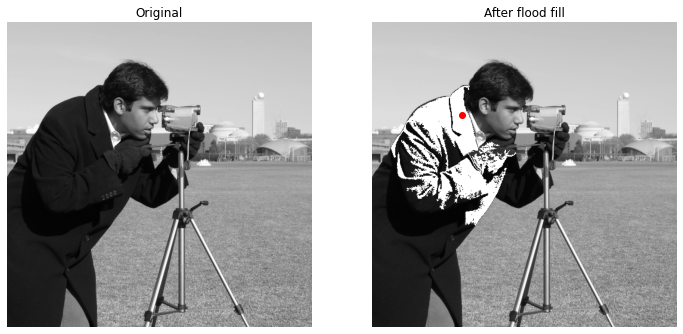

In [28]:
cameraman = skimage.data.camera()

light_coat = skimage.segmentation.flood_fill(cameraman, (155,150), 255, tolerance=10)

fig, ax = plt.subplots(ncols=2, figsize=(12,6))

ax[0].set_title('Original')
ax[0].imshow(cameraman, cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].set_title('After flood fill')
ax[1].plot(150, 155, 'ro')
ax[1].imshow(light_coat, cmap=plt.cm.gray)
ax[1].axis('off')

plt.show()

The cameraman's coat is varying shades of gray. Only the parts of the coat matching the shade near the seed value is changed.

#### Experimentation with tolerance

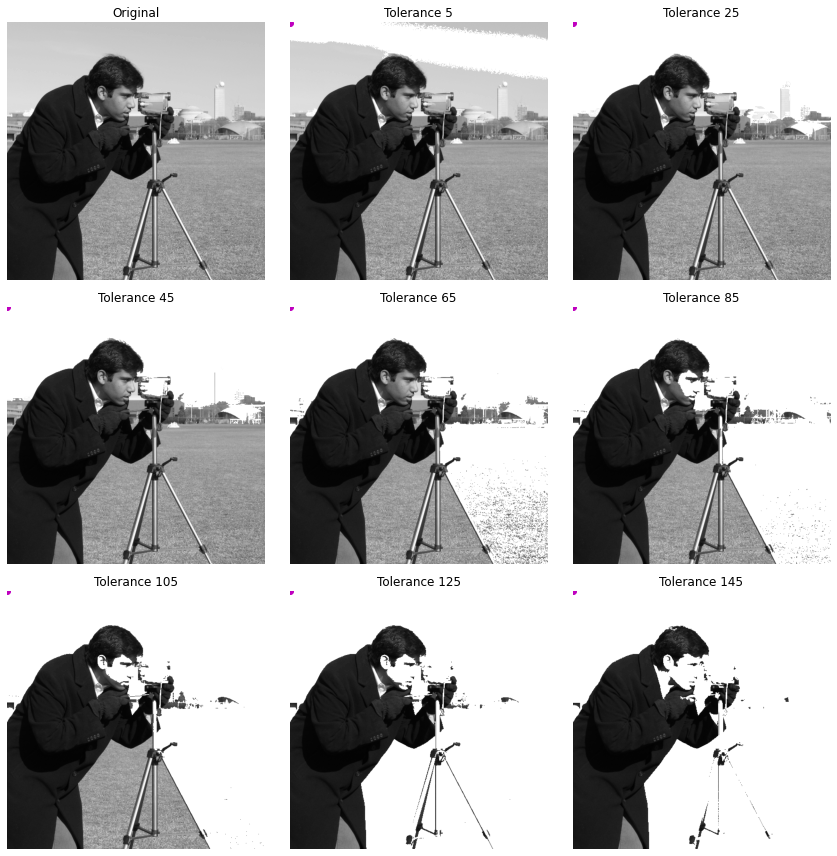

In [30]:
output = []

for i in range(8):
    tol = 5 + 20 * i
    output.append(skimage.segmentation.flood_fill(cameraman, (0,0), 255, tolerance=tol))

# Initialize plot and place original image
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
ax[0, 0].set_title('Original')
ax[0, 0].imshow(cameraman, cmap=plt.cm.gray)
ax[0, 0].axis('off')

# Plot all eight different tolerances for comparison
for i in range(8):
    m, n = np.unravel_index(i + 1, (3,3))
    ax[m, n].set_title(f'Tolerance {5 + 20 * i}')
    ax[m, n].imshow(output[i], cmap=plt.cm.gray)
    ax[m, n].plot(0,0, 'mo')
    ax[m, n].axis('off')

fig.tight_layout()
plt.show()

#### Flood as mask
A sister function `flood` is availabe which returns a mask indentifying the flood rather than modifying the image itself. This is useful for segmentation purposes and more advanced analysis pipelines.

Here we segment the nose of a cat. However, multi-channel images are not supported by `flood` or `flood_fill`. Instead we Sobel filter the red channel to enhance edges, then flood the nose with a tolerance.

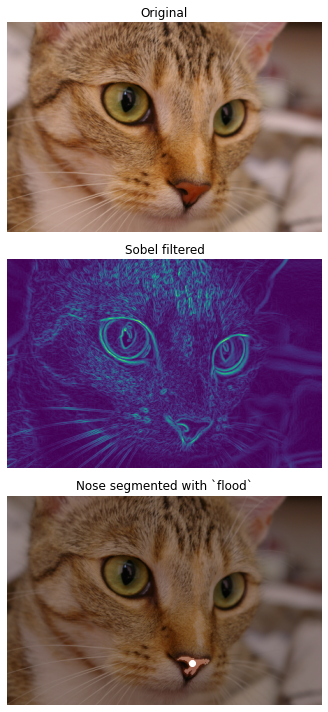

In [40]:
cat = skimage.data.chelsea()
cat_sobel = skimage.filters.sobel(cat[..., 0])
cat_nose = skimage.segmentation.flood(cat_sobel, (240, 265), tolerance=0.03)

fig, ax = plt.subplots(nrows=3, figsize=(12, 10))

ax[0].set_title('Original')
ax[0].imshow(cat)
ax[0].axis('off')

ax[1].set_title('Sobel filtered')
ax[1].imshow(cat_sobel)
ax[1].axis('off')


ax[2].set_title('Nose segmented with `flood`')
ax[2].imshow(cat)
ax[2].imshow(cat_nose, cmap=plt.cm.gray, alpha=0.3)
ax[2].plot(265, 240, 'wo') # seed point
ax[2].axis('off')


fig.tight_layout()
plt.show()

#### Flood-fill in HSV space and mask post-processing
Since flood fill operates on single-channel images, we transform here image to HSV (Hue, Saturation, Value) space in order to flood pixels of similar hue.

Int this example we also show that it is possible to post-process the binary mask returned by `skimage.segmentation.flood()` thanks to the functions of `skimage.morphology`.

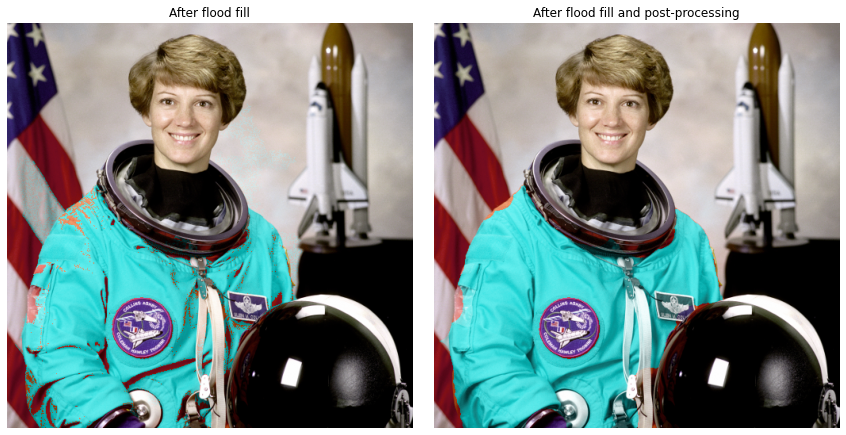

In [43]:
img = skimage.data.astronaut()
img_hsv = skimage.color.rgb2hsv(img)
img_hsv_copy = img_hsv.copy()

# flood function returns a mask of flooded pixels
mask = skimage.segmentation.flood(img_hsv[..., 0], (313, 160), tolerance=0.016)
# Set pixels of mask to new value for hue channel
img_hsv[mask, 0] = 0.5

# Post-processing in order to improve the result
# Remove white pixels from flag, using saturation channel
mask_postprocessed = np.logical_and(mask,
                                    img_hsv_copy[..., 1] > 0.4)

# Remove this structures with binary opening
mask_postprocessed = skimage.morphology.binary_opening(mask_postprocessed, np.ones((3,3)))

# Fill small holes with binary closing
mask_postprocessed = skimage.morphology.binary_closing(mask_postprocessed, skimage.morphology.disk(20))

img_hsv_copy[mask_postprocessed, 0] = 0.5

fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].set_title("After flood fill")
ax[0].imshow(skimage.color.hsv2rgb(img_hsv))
ax[0].axis('off')

ax[1].set_title("After flood fill and post-processing")
ax[1].imshow(skimage.color.hsv2rgb(img_hsv_copy))
ax[1].axis('off')

fig.tight_layout()
plt.show()

## Examples using `skimage.color.label2rgb`

Return an RGB image where color-coded labels are paintedover the image.

### Local Binary Pattern for texture 
[link to example](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html#sphx-glr-auto-examples-features-detection-plot-local-binary-pattern-py)

In [44]:
import numpy as np
import matplotlib.pyplot as plt

Before trying Local Binary Pattern (LBP) on an image, it helps to look at a schematic of LBPs. The below code is just to plot the schematic. 

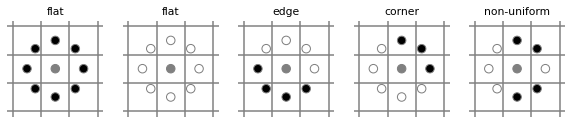

In [48]:
METHOD = 'uniform'
plt.rcParams['font.size'] = 9

def plot_circle(ax, center, radius, color):
    circle = plt.Circle(center, radius, facecolor=color, edgecolor='0.5')
    ax.add_patch(circle)

def plot_lbp_model(ax, binary_values):
    """Draw the schematic for a local binary pattern."""
    # Geometry spec
    theta = np.deg2rad(45)
    R = 1
    r = 0.15
    w = 1.5
    gray = '0.5'

    # Draw the central pixel.
    plot_circle(ax, (0,0), radius=r, color=gray)
    # Draw the surrounding pixels.
    for i, facecolor in enumerate(binary_values):
        x = R * np.cos(i * theta)
        y = R * np.sin(i * theta)
        plot_circle(ax, (x, y), radius=r, color=str(facecolor))

    # Draw the central pixel.
    for x in np.linspace(-w, w, 4):
        ax.axvline(x, color=gray)
        ax.axhline(x, color=gray)

    # Tweak the layout.
    ax.axis('image')
    ax.axis('off')
    size = w + 0.2
    ax.set_xlim(-size, size)
    ax.set_ylim(-size, size)


fig, axes = plt.subplots(ncols=5, figsize=(10,5))

titles = ['flat', 'flat', 'edge', 'corner', 'non-uniform']

binary_patterns = [
    np.zeros(8),
    np.ones(8),
    np.hstack([np.ones(4), np.zeros(4)]),
    np.hstack([np.zeros(3), np.ones(5)]),
    [1, 0, 0, 1, 1, 1, 0, 0]
]

for ax, values, name in zip(axes, binary_patterns, titles):
    plot_lbp_model(ax, values)
    ax.set_title(name)

The figure above shows example results with black (or white) representing pixels that are less (or more) intense than the central pixel. When surrounding pixels are all black or white, then image region is *flat* (i.e. featureless). Groups of continuous black or white pixels are considered "uniform" patterns that can be interpreted as corners or edges. If pixels switch back-and-forth between black and white pixels, the patern is considered "non-uniform".

When using LBP to detect texture, you measure a collection of LBPs over an image patch and look at the distribution of these LBPs. Let's apply LBP to a brick texture:

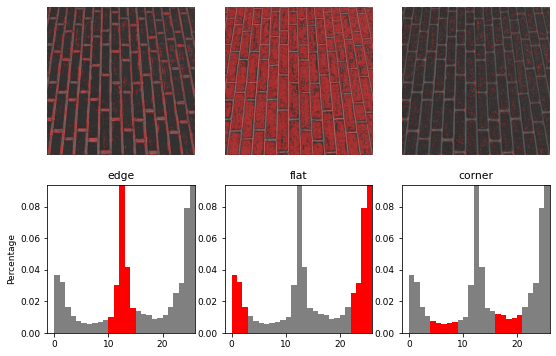

In [53]:
import skimage

# settings for LBP
radius = 3
n_points = 8 * radius

def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return skimage.color.label2rgb(mask, image=image, bg_label=0, alpha=0.5)

def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')

image = skimage.data.brick()
lbp = skimage.feature.local_binary_pattern(image, n_points, radius, METHOD)

def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5')


# Plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9,6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w +  1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4        # 1/4th of histogram
i_34 = 3 * (n_points // 4)  # 3/4th of histogram
corner_labels = (
    list(range(i_14 - w, i_14 + w + 1)) +
    list(range(i_34 - w, i_34 + w + 1))
)

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

The above plot highlights flat, edge-like, and corner-like regions of image.

The histogram of the LBP result is a good measure to classify textures. Here, we test the histogram distributions against each other using the Kullback-Leibler-Divergence.

Rotated images matched againts references using LBP:
original: brick, rotated: 30deg - match result: brick
original: brick, rotated: 70deg - match result: brick
original: grass, rotated: 145deg - match result: grass


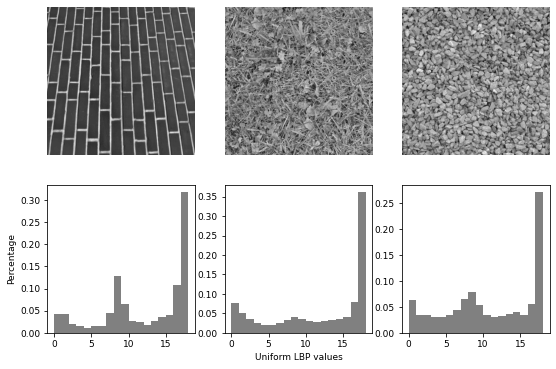

In [67]:
# Setting of LBP
radius = 2
n_points = 8 * radius

def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

def match(refs, img):
    best_score = 10
    best_name = None
    lbp = skimage.feature.local_binary_pattern(img, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    for name, ref in refs.items():
        ref_hist, _ = np.histogram(ref, density=True, bins=n_bins, range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        if score < best_score:
            best_score = score
            best_name = name
    return best_name


brick = skimage.data.brick()
grass = skimage.data.grass()
gravel = skimage.data.gravel()

refs = {
    'brick': skimage.feature.local_binary_pattern(brick, n_points, radius, METHOD),
    'grass': skimage.feature.local_binary_pattern(grass, n_points, radius, METHOD),
    'gravel': skimage.feature.local_binary_pattern(gravel, n_points, radius, METHOD)
}

# classify rotated textures
print("Rotated images matched againts references using LBP:")
print("original: brick, rotated: 30deg - match result:", 
        match(refs, skimage.transform.rotate(brick, angle=30, resize=False)))
print("original: brick, rotated: 70deg - match result:",
        match(refs, skimage.transform.rotate(brick, angle=70, resize=False)))
print("original: grass, rotated: 145deg - match result:",
        match(refs, skimage.transform.rotate(grass, angle=145, resize=False)))

# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(9,6))
plt.gray()

ax1.imshow(brick)
ax1.axis('off')
hist(ax4, refs['brick'])
ax4.set_ylabel('Percentage')

ax2.imshow(grass)
ax2.axis('off')
hist(ax5, refs['grass'])
ax5.set_xlabel('Uniform LBP values')

ax3.imshow(gravel)
ax3.axis('off')
hist(ax6, refs['gravel'])

plt.show()

### RAG Thresholding
[link to example](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rag_mean_color.html#sphx-glr-auto-examples-segmentation-plot-rag-mean-color-py)

This example constructs a Region Adacency Graph (RAG) and merges regions which are similar in color. We construct RAG and define edges as the difference in mean color. We then join regions with similar mean color.

In [68]:
import skimage
import matplotlib.pyplot as plt

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

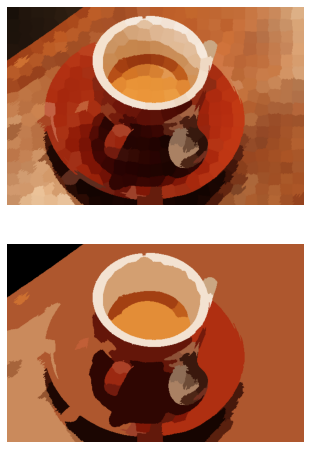

In [70]:
img = skimage.data.coffee()

labels_1 = skimage.segmentation.slic(img, compactness=30, n_segments=400, start_label=1)
out_1 = skimage.color.label2rgb(labels_1, img, kind='avg', bg_label=0)

rag_2 = skimage.future.graph.rag_mean_color(img, labels_1)
labels_2 = skimage.future.graph.cut_threshold(labels_1, rag_2, 29)
out_2 = skimage.color.label2rgb(labels_2, img, kind='avg', bg_label=0)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6,8))

ax[0].imshow(out_1)
ax[1].imshow(out_2)

for a in ax:
    a.axis('off')

plt.tight_layout